# Deep Learning with Game Of Life

# Part I: Introduction

This is the first part on a series of notebooks that I plan to do as I go along the courses in the specialization. While I recognized that the Game of Life rules do not result in a very large dataset (usually deep learning is most efficient when there is a lot of data to learn from), my initial observations with logistic regression here implied that it might work well as a training field to apply what I learn in practice. My hypothesis before starting with this first notebook was that most probably the convolutional neural nets would provide best solution for the problem, and when googling around a bit, I found this example: [http://danielrapp.github.io/cnn-gol/](http://danielrapp.github.io/cnn-gol/). I also bumped onto some debate around whether the Game of Life is something that you can apply neural networks on in Youtube (https://www.youtube.com/watch?v=oqo0k_4OvBI), but as there seemed not to be a flood of material available, it felt appropriate to go on with my own little tests.

2021 update: It's nice to see that the domain gets interest from others too, a late 2020 paper from Swarthmore College and the Los Alamos National Laboratory discusses how [It's Hard for Neural Networks To Learn the Game of Life](https://arxiv.org/abs/2009.01398).

### Setting up the scene

I guess most of us who started with 8-bit computers know what Game of Life is, and pretty big portion have done an implementation on some platform and language back in the day. For the younger generations it might not be as widely known (even though there seems to be a number of practitioners who are still actively participating in discussion and research at http://www.conwaylife.com/forums/). For a quick recap:

##### Game of life rules

In a (potentially infinite) two-dimensional grid of square cells, every cell is either live or dead, and the cells change status on each game iteration according to four rules related to the current cell state and the state of neighbouring cell states (so called [Moore neighborhood](https://en.wikipedia.org/wiki/Moore_neighborhood)) as follows :

1. A live cell with fewer than two live neighbour dies (underpopulation)
2. A live cell with two or three live neighbours lives on to next generation
3. A live cell with more than three live neighbours dies (overpopulation)
4. A dead cell with exactly three live neighbours becomes a live cell (spawning / reproduction)

##### Applying the rules in 3x3 grid

Since the ruleset decides on the (binary - i.e. dead or alive) status of a cell based on its current status and status of its adjacent cells, the number of possible permutations for a minimal game grid of 3x3 is 2^(3*3) = 2^9 = 512. 

I studied a bit the alternatives for implementing the game of life ruleset in Python, and bumped upon this blog post: http://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/. The one with numpy generator expressions was pretty impressive so I packed that into my gol_utils.py library that this notebook uses:

```python
def life_step_1(X):
    """Game of life step using generator expressions"""
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (nbrs_count == 3) | (X & (nbrs_count == 2))
```

The blog post states that it is not *"extremely performant: they involve creating several temporary arrays, and will not work well for large problems with many time steps"*. I tested it and yes, this algorithm starts to clog with grids that have more than millions of cells. For my purposes it is just perfect though. 

The following code block is first generating the 3x3 bitfield permutations as numpy arrays, and then storing the status of the center cell on each permutation pre and post game step in respective arrays (```centers``` and ```truths```). These arrays are then used to filter the permutations into arrays that represent the spread of applied rules.

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as clrs

%matplotlib inline

# Import local utility functions
from utils import gol_utils as gol

In [2]:
## Create all possible permutations of 3x3 array
permutations = np.asarray([gol.bitfield(x) for x in range(0, (2**9))])
centers = np.asarray([(p[1][1]) for p in permutations])
truths = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in permutations])

## Prepare the sets for all combinations of pre/post iteration statuses
lived = permutations[(1 == centers) & (1 == truths)]
spawned = permutations[(0 == centers) & (1 == truths)]
died = permutations[(1 == centers) & (0 == truths)]
empty = permutations[(0 == centers) & (0 == truths)]

### Analysing the result sets

To gain some intuition about the result, the following diagram plot shows visually how the result set is spread. Some things that can be noticed at first glance: Number of cells that either spawn or stay alive is 27.35% which explains why a game of life tends to end to a still life after enough generations have been run - it is just a statistical fact. 

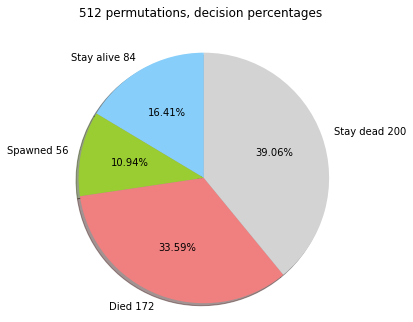

In [3]:
sets = [lived, spawned, died, empty]
setnames = 'Stay alive', 'Spawned', 'Died', 'Stay dead' 

labels = []
sizes = []
fig1, ax1 = plt.subplots(figsize=(5,5))
for i in range(0,4):
    labels.append(setnames[i] + ' ' + str(sets[i].shape[0]))
    sizes.append(sets[i].shape[0])

plt.suptitle("512 permutations, decision percentages")
ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
       shadow=True, startangle=90, colors = ['lightskyblue', 'yellowgreen', 'lightcoral', 'lightgray'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Permutations plotted with the decision spread

What is not immediately visible in the above pie chart is that the dataset actually splits in half between permutations that result the following statuses:

- death (33.59%) or staying alive (16.41%) == 50%
- spawning (10.94%) or staying dead (39.06%) == 50%

When I tried to visualize each permutation and the rule decision on it, I found a way to plot all the permutations with an alternating color scheme in one figure. I did some tests and then decided that I'll put it on a 32 x 16 grid. I was a bit surprised to see how the resulting graph came out. In my opinion, it works as an example of information aesthetics - data presentation can be informative and visually appealing at the same time.

I'm not a pro with matplotlib, and in my opinion plotting the next graph takes a lot of time. Optimization suggestions welcome.

The decision spread graph color legend follows the above pie chart colors: Gray means staying dead, green means spwaning, red means dying, blue means staying alive.

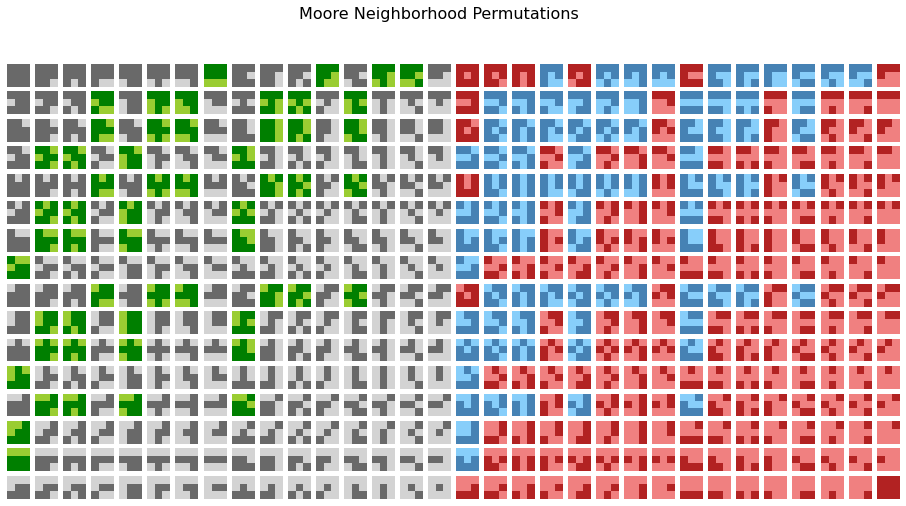

In [4]:
## Visualizing the decision spread:
plt.figure(figsize=(16,8))
plt.suptitle('Moore Neighborhood Permutations', fontsize=16)

colors = {"00":clrs.ListedColormap(['dimgray','lightgray']), #empty cells that stay dead
          "01":clrs.ListedColormap(['g','yellowgreen']),     #cells that spawn
          "11":clrs.ListedColormap(['steelblue','lightskyblue']), #alive cells that stay alive
          "10":clrs.ListedColormap(['firebrick', 'lightcoral'])} #alive cells that die

for index in range(0, permutations.shape[0]):
    old = permutations[index][1][1]
    new = gol.life_step_standard_rules(permutations[index])[1][1]
    colorkey = str(old)+str(new)
    key = colors[colorkey]
    plt.subplot(16, 32,index+1)
    plt.axis("off")
    plt.imshow(permutations[index], cmap=key)
    
    

### Summary

Based on how the cells that spawn (green) and cells that stay alive (blue) are spread on the graph above my initial assumption was that an algorithm that attempt to map this problem to a binary true/false space may not be successful. I wanted to start from the basics though, so the first exercise was about applying simple [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) to the dataset. 

**Next**: [Single Node Logistic Regression](GOL_LR.ipynb)
